In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from numpy import asarray
from sklearn.datasets import make_multilabel_classification
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

#from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split, IterativeStratification

from statsmodels.formula.api import logit
from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv


In [2]:
train = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')

In [7]:
def convertTypes(df):
    df.cp_type = df.cp_type.replace(['trt_cp', 'ctl_vehicle'], [0,1]) 
    df.cp_dose = df.cp_dose.replace(['D1', 'D2'], [0,1])
    return df

def prepareData(max_corr = None
                , PCA_components=None
                , to_csv=False
                , X_train=None
                , X_test=None
                , internal=None
                , random_state=None
                , min_target_positive_count=0
               ):
    
    if X_train is None:
        X_train = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
    
    # To avoid errors, let's get rid of - sign
    X_train.columns = X_train.columns.str.replace('-', '_')

    category_cols = ['cp_type', 'cp_time', 'cp_dose']

    X_train = X_train.copy()  
    X_train = X_train.set_index("sig_id")
    X_train = convertTypes(X_train)
#     for col in category_cols:
#         X_train[col] = X_train[col].astype('category').cat.codes
#         X_test[col] = X_train[col].astype('category').cat.codes
    
    to_drop = None
    if max_corr is not None:
        try:
            corr
        except NameError:
            corr = X_train.loc[:,~X_train.columns.isin(category_cols)].corr().abs()
            corr = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
            
        to_drop = [column for column in corr.columns if any(corr[column] > max_corr)]
        X_train = X_train.drop(X_train[to_drop], axis=1)
    
    pca = None
    scaler = None
    if PCA_components is not None:      
        ds = X_train.loc[:,~X_train.columns.isin(category_cols)]
        scaler = StandardScaler().fit(ds)
        
        ds = scaler.transform(ds)
        if type(PCA_components) == float:
            # Convert ratio to amount of components
            PCA_components = int(PCA_components*ds.shape[1])
        pca = PCA(n_components = PCA_components, svd_solver='full').fit(ds)
        
        ds = pca.transform(ds)
        X_train = pd.concat([X_train[category_cols], pd.DataFrame(ds, index=X_train.index)], axis=1)
        
        # Make sure columns aren't digits
        X_train.columns = ['_{}'.format(x) if type(x) == int else x for x in X_train.columns]
            
    Y_train = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
    Y_train = Y_train.set_index("sig_id")
    
    Y_train.columns = Y_train.columns.str.replace('-', '_')
    Y_train.columns = Y_train.columns.map('_{}'.format)
    
    Y_test = None
        
    # Remove low count variables
    Y_train = Y_train.loc[:, Y_train.sum()>min_target_positive_count]
    
    # Test 
    if internal is not None:
        np.random.seed(random_state)
        stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[internal, 1.0-internal])#, random_state=random_state)
        train_indexes, test_indexes = next(stratifier.split(X_train.copy().values, Y_train.copy().values))

        X_test, Y_test = X_train.iloc[test_indexes, :], Y_train.iloc[test_indexes, :]
        X_train, Y_train = X_train.iloc[train_indexes, :], Y_train.iloc[train_indexes, :]

#         X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=internal
#                                            , random_state=random_state)

    else: 
        if X_test is None:    
            X_test = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')

        X_test = X_test.copy()
        X_test = X_test.set_index("sig_id")
        X_test = convertTypes(X_test)

        if to_drop is not None:
            # Drop correlated variables
            X_test = X_test.drop(X_test[to_drop], axis=1)
        
        if pca is not None:
            # Apply PCA
            ds = X_test.loc[:,~X_test.columns.isin(category_cols)]
            ds = scaler.transform(ds) 
            ds = pca.transform(ds)
            X_test = pd.concat([X_test[category_cols], pd.DataFrame(ds, index=X_test.index)], axis=1)
            # Make sure columns aren't digits
            X_test.columns = ['_{}'.format(x) if type(x) == int else x for x in X_test.columns]

    
    
    if to_csv:
        # Save
        name = '_' + str(X_train.shape[0]) + 'x' + \
            str(X_train.shape[1]) + '_' + \
            (f'thres_{threshold}_' if threshold is not None else '') + \
            (f'PCA_{PCA}' if PCA is not None else '') + \
            '.csv'
        path = '/kaggle/working/'
        X_train.to_csv(path + 'X_train' + name)
        X_test.to_csv(path + 'X_test' + name)
        Y_train.to_csv(path + 'Y_train' + name)
        Y_test.to_csv(path + 'Y_test' + name)
    
    return ((X_train, X_test), (Y_train, Y_test)) 

In [8]:
((X_train, X_test), (Y_train, Y_test)) = prepareData(X_train = train.copy()
                                                     , max_corr = 0.85
                                                     , PCA_components=0.5
                                                     , internal=0.2
                                                     , random_state=0
                                                     , min_target_positive_count=20
                           )

In [9]:
X_train.shape

(19051, 397)

In [10]:
Y_train.shape

(19051, 153)

In [11]:
X_train

,cp_type,cp_time,cp_dose,_0,_1,_2,_3,_4,_5,_6,...,_384,_385,_386,_387,_388,_389,_390,_391,_392,_393
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000779bfc,0,72,0,-5.335785,3.677493,7.353432,-4.216403,-1.628184,4.276067,1.973340,...,-0.145616,0.230977,-0.371114,-0.072074,0.303842,0.363656,-0.322266,-0.878438,-0.258089,0.423399
id_0015fd391,0,48,0,6.648789,-2.667970,-5.223251,-8.870119,1.273807,-6.474398,2.746591,...,0.107676,0.264256,0.822473,-0.024438,-1.471409,0.241744,-0.219937,0.652439,0.120217,-0.830609
id_001626bd3,0,72,1,-5.846146,0.924661,4.146178,-8.519638,1.775049,-3.271837,-1.263842,...,1.593037,-0.027410,-0.235282,0.486410,-0.744601,-0.785935,-0.064577,-1.167812,0.301089,-0.136042
id_001762a82,0,24,0,-7.450434,1.373725,1.677457,-2.034177,1.455680,2.081902,1.433187,...,-0.128286,-0.291944,0.331659,-0.562879,0.554984,-0.240914,-0.583993,-0.383675,-0.888793,-0.596956
id_001bd861f,0,24,1,6.460661,1.008432,-3.785721,-2.031017,1.917541,12.943085,4.664408,...,-1.619560,0.235904,-0.494354,3.733693,1.108179,1.494237,1.752906,-2.418682,0.377266,0.888824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id_fff8c2444,0,72,0,-5.162371,0.600669,-1.929275,-0.838583,-0.184353,-0.100436,-0.933743,...,-0.100390,-0.026828,0.016426,0.068277,0.329539,0.001363,0.156138,0.129476,0.091596,0.003477
id_fffb1ceed,0,24,1,-4.130047,2.448508,-1.957704,-2.767196,-0.216648,-0.055431,0.968091,...,-0.303698,-0.021351,-0.429835,0.451659,-0.049632,0.452498,-0.072385,0.046342,0.002564,0.590412
id_fffb70c0c,0,24,1,-3.877836,-0.736141,-2.071996,1.529145,3.442990,0.810759,-0.869588,...,0.254783,-0.071257,-0.213280,0.212456,-0.198165,0.162160,0.301946,-0.111369,-0.094538,0.019320


In [12]:
Y_test

,_acat_inhibitor,_acetylcholine_receptor_agonist,_acetylcholine_receptor_antagonist,_acetylcholinesterase_inhibitor,_adenosine_receptor_agonist,_adenosine_receptor_antagonist,_adrenergic_receptor_agonist,_adrenergic_receptor_antagonist,_akt_inhibitor,_alk_inhibitor,...,_tnf_inhibitor,_topoisomerase_inhibitor,_trpv_agonist,_trpv_antagonist,_tubulin_inhibitor,_tyrosine_kinase_inhibitor,_vegfr_inhibitor,_vitamin_b,_vitamin_d_receptor_agonist,_wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_000a6266a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_0020d0484,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_002452c7e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_002e08ff8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id_ffd241f1c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_ffdd24c81,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_fff26b3c2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Variable Selection

In [20]:
corr = X_train.corr()

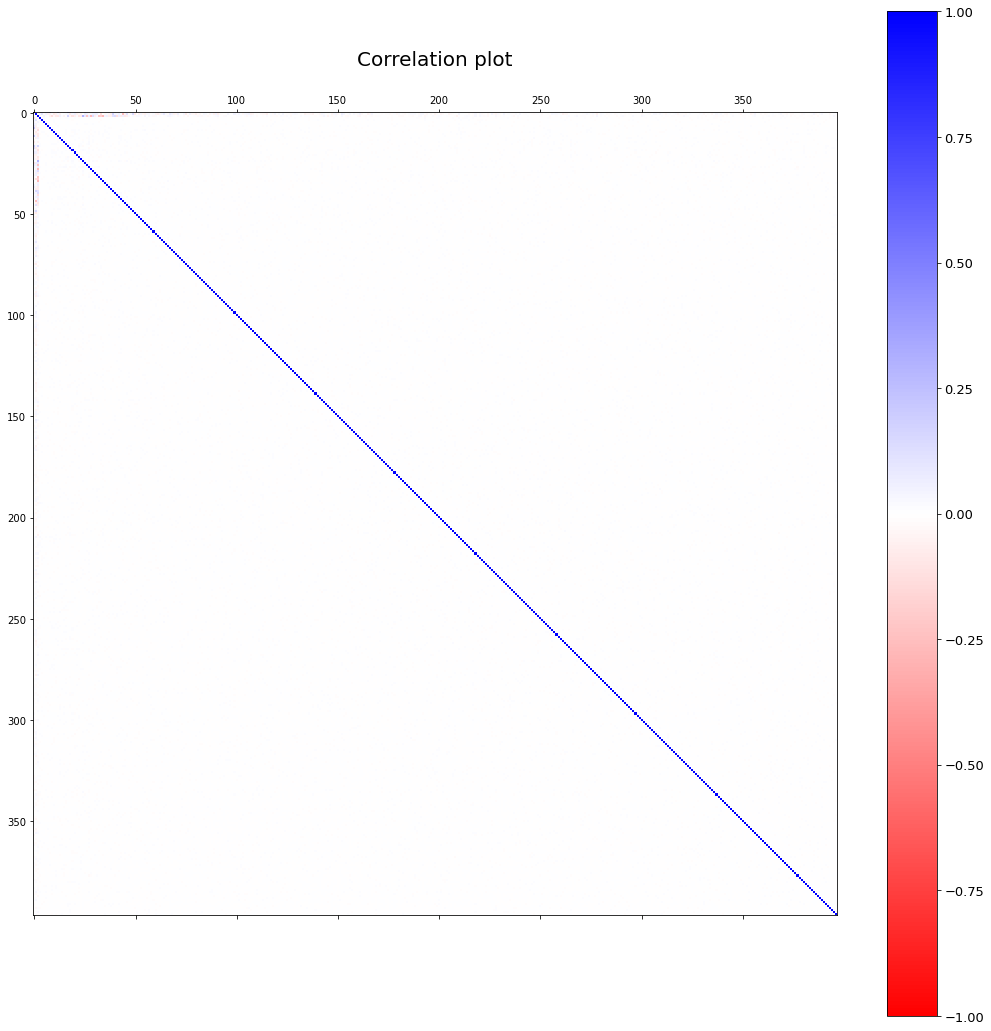

In [21]:
fig = plt.figure(
    figsize=(18, 18)
)

plt.matshow(
    corr
    , fignum=fig.number
    , cmap="bwr_r"
    , vmin=-1
    , vmax=1
)

plt.title("Correlation plot", fontsize=20)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=13)

In [9]:
print(f"Maximum correlation: {corr.values.ravel()[corr.abs().values.ravel()<0.98].max()}")

Maximum correlation: 0.29604210377357965


In [19]:
def forward_selection(data
                      , response
                      , attribute
                      , selected
                      , remaining
                      , batch_accept_score_rate=0.5
                     ):
            
    # If no selected variables
    current_score = float('inf')
    # else
    if selected != set():
        # First compute score with all present variables
        model = sm.GLM(data.loc[:,response], data.loc[:,selected], family=sm.families.Binomial(sm.families.links.logit())).fit()

        current_score = getattr(model, attribute)
    
    #print("Forward selection.")
    
    scores_with_candidates = []
    remove_remaining = set()

    # Add
#     counter = 0
    for candidate in remaining:
        selected.add(candidate)
        
#         counter+=1
#         if counter in np.linspace(0, len(remaining), 5).astype(int):
#             print(f"Trying with: {counter}, {candidate}")

        try:
            model = sm.GLM(data.loc[:,response], data.loc[:,selected], family=sm.families.Binomial(sm.families.links.logit())).fit()
        except Exception as e:
            #print(f'Error with "{candidate}": '+ str(e))
            selected.remove(candidate)
            remove_remaining.add(candidate)
            continue
        
        # Get SCORE (AIC, BIC...)
        score = getattr(model, attribute)
        scores_with_candidates.append((score, candidate))

        selected.remove(candidate)
    
    if scores_with_candidates == []:
        return selected, remaining, False, current_score
    
    # Remove items that throwed an error
    for item in remove_remaining:
        remaining.remove(item)
            
    # Sort from best to worst score (min to max)
    scores_with_candidates = sorted(scores_with_candidates)
    
    best_current_score, best_candidate = scores_with_candidates[0]
    # Check if there are improvements
    if best_current_score > current_score:
        print("Adding variables isn't helpful")
        print(best_current_score, current_score)
        return selected, remaining, False, current_score
    
    if batch_accept_score_rate is not None:
        worst_current_score, _ = scores_with_candidates[-1]
        max_accepted = best_current_score + (worst_current_score-best_current_score)*batch_accept_score_rate

        for score, candidate in scores_with_candidates:
            if score > max_accepted:
                break
            # else
            #print(f"Adding {candidate} to the model.")
            remaining.remove(candidate)
            selected.add(candidate)
        
        return selected, remaining, True, None            
    
    #else:
    remaining.remove(best_candidate)
    selected.add(best_candidate)
    
    return selected, remaining, True, best_current_score


def backward_selection(data
                      , response
                      , attribute
                      , selected
                      , remaining
                      ,current_score=None
                      ):
    if len(selected) <= 1:
        return selected, remaining, False, current_score
    
    if current_score is None:
        # First compute score with all present variables
        model = sm.GLM(data.loc[:,response], data.loc[:,selected], family=sm.families.Binomial(sm.families.links.logit())).fit()

        current_score = getattr(model, attribute)

    #print("Backward selection.")
    #print(f"Current {attribute} score: {current_score}")
    #print(f"Amount of selected variables: {len(selected)}\n")
    
    scores_with_candidates = []
        
    # Remove
    for candidate in selected.copy():
        selected.remove(candidate)
        
        #print(f"Back. Trying to remove {candidate}")
        model = sm.GLM(data.loc[:,response], data.loc[:,selected], family=sm.families.Binomial(sm.families.links.logit())).fit()
        
        # Get SCORE (AIC, BIC...)
        score = getattr(model, attribute)
        scores_with_candidates.append((score, candidate))

        selected.add(candidate)
            
    # Sort from best score to worst (min to max)
    scores_with_candidates = sorted(scores_with_candidates)
    
    best_current_score, worst_candidate = scores_with_candidates.pop()
    
    if best_current_score > current_score:
        #print("Removing variables isn't helpful")
        return selected, remaining, False, current_score
    # else
    #print(f"Removing {worst_candidate} to the model.")
    selected.remove(worst_candidate)
    
    return selected, remaining, True, None


def selection(data, response, attribute, extra_variables=[], selected = None, batch_forward=True):
    remaining = set(data.columns)
    remaining.update(extra_variables)
    remaining.remove(response)
    
    if selected is None:
        selected = set()
    else:
        remaining.difference_update(selected)
    
    if not batch_forward:
        changes = True
        while changes:
            selected, remaining, changes, current_score = forward_selection(data, response, attribute, selected, remaining, batch_accept_score_rate = False)
    
    else:
        selected, remaining, changes, current_score = forward_selection(data, response, attribute, selected, remaining)
        while changes:
            while changes:
                selected, remaining, changes, current_score = backward_selection(data, response, attribute, selected, remaining, current_score=current_score)

            selected, remaining, changes, current_score = forward_selection(data, response, attribute, selected, remaining)
                
    if len(selected) == 0:
        print("Aborting: No variables were selected.")
        return None, '', set()
        
    #formula = "{} ~ {}".format(response, ' + '.join(selected))
    #print(f"\nFinal model: {formula}. {attribute} = {current_score}")
    
    model = sm.GLM(data.loc[:,response], data.loc[:,selected], family=sm.families.Binomial(sm.families.links.logit())).fit()
    score = getattr(model, attribute)

    return response, selected, score

In [20]:
selected_variables = {}
responses = []
scores = []
selected_total = set()

cols = Y_train.columns.to_list()#[2:]
for col, selected in selected_variables.items():
    selected_total.update(selected)
    cols.remove(col)
print(len(selected_total))
print(len(selected_variables))

for column in cols:
    #print(f"Selection for {column}")
    response, selected, score = selection(pd.concat([X_train.drop(columns=['cp_type', 'cp_time', 'cp_dose']), Y_train[column]], axis=1)
                               , column, 'aic')
   
    print(f'selected_variables["{response}"] = {selected}')    
    
    selected_variables[response] = [selected]
    scores += [score]
    selected_total.update(selected)


0
0
Adding variables isn't helpful
26412.671581011422 26411.464615399593
selected_variables["_acat_inhibitor"] = {'_380'}
Adding variables isn't helpful
26412.531980952233 26411.407685078844
selected_variables["_acetylcholine_receptor_agonist"] = {'_10'}


KeyboardInterrupt: 

In [18]:
selected_variables = {}
responses = []
scores = []
selected_total = set()

cols = Y_train.columns.to_list()#[2:]
for col, selected in selected_variables.items():
    selected_total.update(selected)
    cols.remove(col)
print(len(selected_total))
print(len(selected_variables))

for column in cols:
    #print(f"Selection for {column}")
    response, selected, score = selection(pd.concat([X_train.drop(columns=['cp_type', 'cp_time', 'cp_dose']), Y_train[column]], axis=1)
                               , column, 'aic')
   
    print(f'selected_variables["{response}"] = {selected}')    
    
    selected_variables[response] = [selected]
    scores += [score]
    selected_total.update(selected)


0
0
Adding variables isn't helpful
26411.201459011165 26410.638148507
selected_variables["_acat_inhibitor"] = {'_257'}
Adding variables isn't helpful
26411.173760145746 26410.556967246313
selected_variables["_acetylcholine_receptor_agonist"] = {'_209'}
Adding variables isn't helpful
26410.273307403 26410.269340335468
selected_variables["_acetylcholine_receptor_antagonist"] = {'_146'}


KeyboardInterrupt: 

In [ ]:
selected_total

## The following cells are previous versions of the functions, saved for reference.

In [26]:
def forward_selection(data
                      , response
                      , attribute
                      , selected
                      , batch_accept_score_rate=0.5
                     ):
    remaining = set(data.columns)
    remaining.remove(response)
    if len(selected)>0:
        remaining.difference_update(selected)
            
    # If no selected variables
    current_score = float('inf')
    # else
    if selected != set():
        # First compute score with all present variables
        model = sm.GLM(data.loc[:,response], data.loc[:,selected], family=sm.families.Binomial(sm.families.links.logit())).fit()

        current_score = getattr(model, attribute)
    
    #print("Forward selection.")
    
    scores_with_candidates = []
    remove_remaining = set()

    # Add
#     counter = 0
    for candidate in remaining:
        selected.add(candidate)

#         counter+=1
#         if counter in np.linspace(0, len(remaining), 5).astype(int):
#             print(f"Trying with: {counter}, {candidate}")

        try:
            model = sm.GLM(data.loc[:,response], data.loc[:,selected], family=sm.families.Binomial(sm.families.links.logit())).fit()
        except Exception as e:
            print(f'Error with "{candidate}": '+ str(e))
            selected.remove(candidate)
            remove_remaining.add(candidate)
            continue
        
        # Get SCORE (AIC, BIC...)
        score = getattr(model, attribute)
        scores_with_candidates.append((score, candidate))

        selected.remove(candidate)
    
    if scores_with_candidates == []:
        return selected, remaining, False, current_score
    
    # Remove items that throwed an error
    for item in remove_remaining:
        remaining.remove(item)
            
    # Sort from best to worst score (min to max)
    scores_with_candidates = sorted(scores_with_candidates)

    return scores_with_candidates

column = '_acat_inhibitor'
scores_with_candidates = forward_selection(pd.concat([X_train.drop(columns=['cp_type', 'cp_time', 'cp_dose']), Y_train[column]], axis=1)
                               , column, 'aic', selected = set())
    

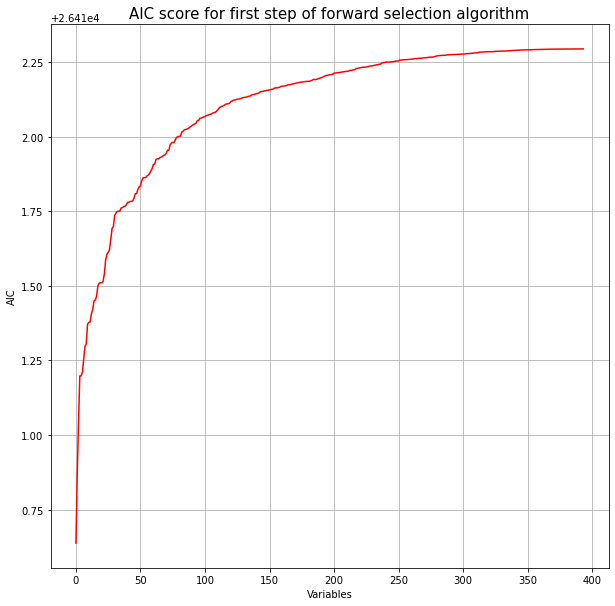

In [30]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(range(len(scores_with_candidates)), [x for x,y in scores_with_candidates], 'r-')

plt.title("AIC score for first step of forward selection algorithm", fontsize=15)
plt.ylabel("AIC")
plt.xlabel("Variables")
plt.grid()

plt.show()

In [38]:
response = "_5_alpha_reductase_inhibitor"
column = response
data = pd.concat([X_train.drop(columns=['cp_type', 'cp_time', 'cp_dose']), Y_train[column]], axis=1)
selected = {}#{'_262','_281'}
remaining = set(data.columns)
remaining.remove(response)
remaining.difference_update(selected)

model = sm.GLM(data.loc[:,response], data.loc[:,remaining], family=sm.families.Binomial(sm.families.links.logit())).fit()


In [39]:
model.aic

27120.188341439705

In [37]:
model.aic

26411.730881339896

In [35]:
model.aic

26411.439343842336

In [26]:
sorted(a, key=lambda x: x[0], reverse=False)

[(26411.730881339896, '_281'),
 (26412.075014690512, '_301'),
 (26412.11441900694, '_209'),
 (26412.132899605094, '_333'),
 (26412.20555846025, '_152'),
 (26412.211728554423, '_278'),
 (26412.271940194598, '_203'),
 (26412.29433456264, '_146'),
 (26412.363882308076, '_364'),
 (26412.379395242922, '_46'),
 (26412.432238301637, '_375'),
 (26412.52116708243, '_118'),
 (26412.539588734748, '_55'),
 (26412.551126883744, '_161'),
 (26412.552545054565, '_2'),
 (26412.564702883446, '_86'),
 (26412.580571410843, '_22'),
 (26412.616311901016, '_189'),
 (26412.662533994007, '_128'),
 (26412.666555250857, '_32'),
 (26412.694428513267, '_223'),
 (26412.703717942848, '_182'),
 (26412.710266268372, '_66'),
 (26412.729817390336, '_340'),
 (26412.75644913914, '_3'),
 (26412.770855820818, '_325'),
 (26412.78291575131, '_264'),
 (26412.792280649963, '_120'),
 (26412.795774894264, '_65'),
 (26412.81640994769, '_306'),
 (26412.83767688124, '_291'),
 (26412.86254083485, '_77'),
 (26412.864613235, '_168'),
 

In [7]:
if False:
    selected_variables["_5_alpha_reductase_inhibitor"] = {'_223', '_147', '_203', '_189', '_303', '_146', '_252', '_209', '_55', '_278'}
    selected_variables["_11_beta_hsd1_inhibitor"] = {'_223', '_63', '_203', '_189', '_303', '_146', '_209', '_55', '_278'}
    selected_variables["_acat_inhibitor"] = {'_223', '_147', '_203', '_189', '_303', '_146', '_209', '_55'}
    selected_variables["_acetylcholine_receptor_agonist"] = {'_381', '_63', '_189', '_303', '_113', '_209', '_55', '_344'}
    selected_variables["_acetylcholine_receptor_antagonist"] = {'_1', '_152', '_203', '_189', '_265', '_303', '_146', '_0', '_252', '_209', '_55', '_278'}
    selected_variables["_acetylcholinesterase_inhibitor"] = {'_189', '_303', '_146', '_223', '_209', '_55'}
    selected_variables["_adenosine_receptor_agonist"] = {'_131', '_223', '_189', '_303', '_335', '_209', '_55'}
    selected_variables["_adrenergic_receptor_agonist"] = {'_152', '_65', '_246', '_63', '_132', '_173', '_85', '_209', '_196', '_17', '_131', '_223', '_147', '_168', '_303', '_0', '_146', '_55'}
    selected_variables["_adrenergic_receptor_antagonist"] = {'_156', '_1', '_152', '_10', '_246', '_24', '_189', '_303', '_0', '_209', '_55', '_278'}
    selected_variables["_akt_inhibitor"] = {'_42', '_65', '_246', '_24', '_63', '_132', '_173', '_71', '_209', '_223', '_147', '_10', '_203', '_189', '_303', '_146', '_55'}
    selected_variables["_alk_inhibitor"] = {'_131', '_147', '_203', '_189', '_303', '_146', '_209', '_55'}
    selected_variables["_ampk_activator"] = {'_223', '_147', '_246', '_63', '_189', '_303', '_146', '_209', '_55'}
    selected_variables["_analgesic"] = {'_223', '_203', '_189', '_303', '_146', '_209', '_55'}
    selected_variables["_androgen_receptor_agonist"] = {'_131', '_223', '_147', '_24', '_63', '_203', '_189', '_303', '_146', '_252', '_209', '_55'}
    selected_variables["_androgen_receptor_antagonist"] = {'_152', '_223', '_203', '_189', '_303', '_146', '_252', '_209', '_55'}
    selected_variables["_anesthetic___local"] = {'_152', '_63', '_203', '_189', '_265', '_303', '_146', '_209', '_161', '_55'}
    selected_variables["_angiogenesis_inhibitor"] = {'_223', '_147', '_63', '_203', '_189', '_303', '_146', '_209', '_55'}
    selected_variables["_angiotensin_receptor_antagonist"] = {'_152', '_223', '_147', '_189', '_303', '_146', '_209', '_55'}
    selected_variables["_anti_inflammatory"] = {'_152', '_223', '_147', '_24', '_63', '_189', '_303', '_146', '_209', '_55'}
    selected_variables["_antibiotic"] = {'_223', '_147', '_24', '_203', '_189', '_303', '_209', '_55'}
    selected_variables["_anticonvulsant"] = {'_223', '_203', '_189', '_303', '_146', '_209', '_55'}
    selected_variables["_adenosine_receptor_antagonist"] = {'_97', '_380', '_203', '_77', '_382', '_55', '_66', '_189', '_365'}
    selected_variables["_adenylyl_cyclase_activator"] = {'_311'}
    selected_variables["_antifungal"] = {'_295'}
    selected_variables["_antihistamine"] = {'_152'}
    selected_variables["_antimalarial"] = {'_277'}
    selected_variables["_antioxidant"] = {'_264'}
    selected_variables["_antiprotozoal"] = {'_277'}
    selected_variables["_antiviral"] = {'_17', '_118', '_97', '_380', '_77', '_382', '_55', '_152', '_66', '_189', '_365'}
    selected_variables["_apoptosis_stimulant"] = {'_17', '_380', '_203', '_77', '_383', '_382', '_66', '_189', '_301', '_207', '_295', '_365', '_363', '_118', '_97', '_277', '_161', '_274', '_55', '_152', '_37'}
    selected_variables["_aromatase_inhibitor"] = {'_17', '_380', '_203', '_77', '_383', '_382', '_296', '_66', '_189', '_207', '_295', '_365', '_118', '_97', '_277', '_264', '_55', '_152'}
    selected_variables["_atp_synthase_inhibitor"] = {'_380', '_203', '_77', '_339', '_382', '_296', '_66', '_189', '_207', '_365', '_118', '_97', '_2', '_65', '_161', '_55'}
    selected_variables["_atpase_inhibitor"] = {'_17', '_118', '_97', '_22', '_382', '_296', '_55', '_66', '_14', '_189', '_365', '_37'}
    selected_variables["_atr_kinase_inhibitor"] = {'_118', '_97', '_380', '_77', '_382', '_264', '_311', '_296', '_55', '_152', '_66', '_189', '_295', '_365'}
    selected_variables["_aurora_kinase_inhibitor"] = {'_17', '_15', '_31', '_152', '_189', '_146', '_37', '_132'}
    selected_variables["_bacterial_30s_ribosomal_subunit_inhibitor"] = {'_118', '_97', '_380', '_77', '_382', '_264', '_311', '_55', '_66', '_189', '_207', '_37'}
    selected_variables["_bacterial_50s_ribosomal_subunit_inhibitor"] = {'_2'}
    selected_variables["_bacterial_antifolate"] = {'_209'}
    selected_variables["_bacterial_cell_wall_synthesis_inhibitor"] = {'_17', '_380', '_203', '_77', '_18', '_382', '_296', '_189', '_207', '_295', '_365', '_0', '_97', '_2', '_65', '_152'}
    selected_variables["_bacterial_dna_gyrase_inhibitor"] = {'_17', '_380', '_203', '_77', '_178', '_382', '_296', '_66', '_189', '_301', '_365', '_118', '_97', '_177', '_55', '_152'}
    selected_variables["_bacterial_dna_inhibitor"] = {'_164'}
    selected_variables["_bcl_inhibitor"] = {'_207'}
    selected_variables["_bcr_abl_inhibitor"] = {'_380', '_203', '_77', '_382', '_66', '_189', '_207', '_365', '_118', '_97', '_2', '_376', '_31', '_55', '_152'}
    selected_variables["_benzodiazepine_receptor_agonist"] = {'_301'}
    selected_variables["_beta_amyloid_inhibitor"] = {'_17', '_380', '_203', '_77', '_382', '_296', '_66', '_189', '_207', '_365', '_118', '_97', '_161', '_55', '_152'}
    selected_variables["_bromodomain_inhibitor"] = {'_17', '_32', '_12', '_172', '_43', '_18', '_29', '_38', '_152', '_66', '_189'}
    selected_variables["_btk_inhibitor"] = {'_209'}
    selected_variables["_calcium_channel_blocker"] = {'_235'}
    selected_variables["_cannabinoid_receptor_agonist"] = {'_17', '_118', '_97', '_380', '_203', '_295', '_382', '_296', '_55', '_66', '_209', '_189'}
    selected_variables["_cannabinoid_receptor_antagonist"] = {'_17', '_118', '_97', '_77', '_382', '_264', '_296', '_55', '_66', '_189', '_365'}
    selected_variables["_carbonic_anhydrase_inhibitor"] = {'_363'}
    selected_variables["_casein_kinase_inhibitor"] = {'_207'}
    selected_variables["_caspase_activator"] = {'_2'}
    selected_variables["_catechol_o_methyltransferase_inhibitor"] = {'_161'}
    selected_variables["_cc_chemokine_receptor_antagonist"] = {'_204'}
    selected_variables["_cck_receptor_antagonist"] = {'_209'}
    selected_variables["_cdk_inhibitor"] = {'_136', '_312', '_268', '_383', '_18', '_275', '_63', '_35', '_214', '_159', '_89', '_58', '_239', '_21', '_24', '_41', '_192', '_180', '_20', '_13', '_62', '_257', '_132', '_8', '_30', '_370', '_244', '_294', '_376', '_22', '_352', '_29', '_56', '_260', '_33', '_74', '_52', '_296', '_5', '_46', '_243', '_130', '_51', '_110', '_237', '_15', '_82', '_287', '_12', '_107', '_334', '_252', '_223', '_31', '_67', '_105', '_4', '_182', '_168', '_189', '_304', '_60', '_118', '_55', '_45', '_176', '_183', '_284', '_238', '_134', '_48', '_280', '_194', '_292', '_3', '_265', '_1', '_32', '_358', '_209', '_224', '_143', '_255', '_218', '_131', '_120', '_289', '_226', '_273', '_211', '_179', '_340', '_0', '_128', '_201', '_220', '_97', '_68', '_262', '_277', '_106', '_34', '_53', '_95', '_6', '_27', '_251', '_127', '_37', '_36', '_44', '_170', '_305', '_216', '_206', '_339', '_23', '_227', '_59', '_10', '_140', '_14', '_16', '_49', '_172', '_28', '_167', '_38', '_9', '_17', '_92', '_203', '_64', '_94', '_83', '_173', '_78', '_19', '_85', '_375', '_169', '_242', '_7', '_279', '_71', '_2', '_156', '_25', '_157', '_359', '_215', '_11', '_195', '_40', '_184'}
    selected_variables["_chelating_agent"] = {'_97', '_203', '_382', '_264', '_161', '_296', '_55', '_152', '_66', '_209', '_189', '_207', '_365'}
    selected_variables["_chk_inhibitor"] = {'_97', '_382', '_264', '_311', '_55', '_152', '_209', '_66', '_365'}
    selected_variables["_chloride_channel_blocker"] = {'_209'}
    selected_variables["_cholesterol_inhibitor"] = {'_118', '_97', '_380', '_77', '_382', '_296', '_55', '_152', '_66', '_189', '_365'}
    selected_variables["_cholinergic_receptor_antagonist"] = {'_252'}
    selected_variables["_corticosteroid_agonist"] = {'_63'}
    selected_variables["_cyclooxygenase_inhibitor"] = {'_1', '_4', '_301', '_77', '_0'}
    selected_variables["_cytochrome_p450_inhibitor"] = {'_63'}
    selected_variables["_dihydrofolate_reductase_inhibitor"] = {'_17', '_97', '_203', '_382', '_311', '_55', '_152', '_66', '_189', '_365'}
    selected_variables["_dipeptidyl_peptidase_inhibitor"] = {'_118', '_97', '_380', '_203', '_77', '_382', '_264', '_296', '_55', '_66', '_189', '_295', '_365'}
    selected_variables["_dna_alkylating_agent"] = {'_118', '_97', '_380', '_203', '_77', '_382', '_296', '_152', '_66', '_209', '_189', '_365'}
    selected_variables["_dna_inhibitor"] = {'_17', '_20', '_77', '_382', '_90', '_375', '_16', '_189', '_232', '_207', '_365', '_7', '_15', '_97', '_177', '_34', '_251', '_119', '_40', '_37'}
    selected_variables["_dopamine_receptor_agonist"] = {'_66', '_380', '_189', '_365'}
    selected_variables["_dopamine_receptor_antagonist"] = {'_2', '_380', '_203', '_77', '_178', '_55', '_66', '_0', '_9'}
    selected_variables["_egfr_inhibitor"] = {'_18', '_241', '_63', '_35', '_365', '_32', '_249', '_21', '_24', '_264', '_65', '_43', '_20', '_351', '_382', '_226', '_211', '_179', '_301', '_30', '_97', '_22', '_331', '_106', '_34', '_6', '_317', '_29', '_251', '_325', '_56', '_86', '_37', '_216', '_101', '_33', '_77', '_23', '_74', '_47', '_5', '_66', '_16', '_49', '_15', '_12', '_28', '_152', '_38', '_4', '_26', '_250', '_17', '_380', '_19', '_50', '_7', '_228', '_118', '_263', '_2', '_42', '_55', '_184'}
    selected_variables["_estrogen_receptor_agonist"] = {'_118', '_97', '_380', '_203', '_77', '_339', '_383', '_382', '_264', '_66', '_189', '_207'}
    selected_variables["_estrogen_receptor_antagonist"] = {'_118', '_97', '_380', '_203', '_77', '_339', '_382', '_264', '_296', '_66', '_189', '_295', '_365'}
    selected_variables["_faah_inhibitor"] = {'_17', '_118', '_97', '_380', '_203', '_77', '_382', '_264', '_296', '_55', '_152', '_66', '_189', '_365'}
    selected_variables["_farnesyltransferase_inhibitor"] = {'_17', '_118', '_97', '_380', '_203', '_77', '_382', '_296', '_55', '_66', '_209', '_189', '_365'}
    selected_variables["_fatty_acid_receptor_agonist"] = {'_17', '_118', '_380', '_77', '_382', '_296', '_55', '_66', '_209', '_189', '_365'}
    selected_variables["_fgfr_inhibitor"] = {'_295'}
    selected_variables["_flt3_inhibitor"] = {'_48', '_121', '_227', '_257', '_5', '_66', '_189', '_200', '_365', '_15', '_30', '_25', '_31', '_34', '_55', '_29', '_224'}
    selected_variables["_focal_adhesion_kinase_inhibitor"] = {'_17', '_97', '_2', '_380', '_203', '_382', '_296', '_55', '_152', '_176', '_66', '_189', '_365'}
    selected_variables["_free_radical_scavenger"] = {'_17', '_118', '_97', '_380', '_203', '_77', '_339', '_382', '_55', '_152', '_66', '_189', '_365'}
    selected_variables["_fungal_squalene_epoxidase_inhibitor"] = {'_17', '_380', '_203', '_77', '_382', '_311', '_296', '_66', '_189', '_207', '_365', '_118', '_97', '_161', '_55', '_152'}
    selected_variables["_gaba_receptor_agonist"] = {'_17', '_380', '_203', '_77', '_382', '_66', '_189', '_207', '_295', '_365', '_118', '_97', '_252', '_264', '_161'}
    selected_variables["_gaba_receptor_antagonist"] = {'_17', '_97', '_329', '_380', '_203', '_77', '_277', '_65', '_161', '_296', '_55', '_152', '_189', '_365'}
    selected_variables["_gamma_secretase_inhibitor"] = {'_118', '_97', '_66', '_189', '_121', '_382'}
    selected_variables["_glucocorticoid_receptor_agonist"] = {'_156', '_136', '_22', '_71', '_32', '_209', '_23', '_7', '_63', '_230', '_162', '_43', '_31', '_281', '_204', '_217', '_54', '_96', '_26', '_48', '_39', '_33', '_41', '_6', '_25', '_34', '_189', '_184', '_182', '_40', '_79', '_30', '_153', '_57', '_253', '_72', '_37', '_1', '_80', '_24', '_226', '_132', '_388', '_115', '_118', '_20', '_232', '_38', '_321', '_3', '_113', '_15', '_181', '_208', '_55', '_65', '_341', '_86', '_11', '_100', '_47', '_46', '_160', '_335', '_18', '_161', '_128', '_28', '_90', '_36', '_51', '_166', '_0', '_35', '_59', '_14', '_329', '_44', '_104', '_154', '_119', '_53', '_144', '_239', '_81', '_203', '_121'}
    selected_variables["_glutamate_inhibitor"] = {'_209', '_152', '_277', '_203', '_319', '_189'}
    selected_variables["_glutamate_receptor_agonist"] = {'_209', '_203', '_319', '_189'}
    selected_variables["_glutamate_receptor_antagonist"] = {'_1', '_341', '_204', '_19', '_319', '_223', '_289', '_0', '_209', '_118', '_203', '_189'}
    selected_variables["_gonadotropin_receptor_agonist"] = {'_209', '_277', '_203', '_189'}
    selected_variables["_gsk_inhibitor"] = {'_247', '_341', '_80', '_277', '_319', '_152', '_42', '_203', '_189'}
    selected_variables["_hcv_inhibitor"] = {'_209', '_203', '_319', '_189'}
    selected_variables["_hdac_inhibitor"] = {'_275', '_22', '_13', '_29', '_32', '_209', '_56', '_308', '_7', '_43', '_277', '_54', '_19', '_26', '_21', '_292', '_48', '_197', '_8', '_33', '_39', '_6', '_219', '_34', '_101', '_66', '_68', '_40', '_50', '_4', '_37', '_1', '_80', '_17', '_148', '_118', '_20', '_38', '_180', '_3', '_52', '_15', '_123', '_55', '_341', '_11', '_10', '_47', '_46', '_88', '_84', '_138', '_18', '_161', '_2', '_293', '_128', '_28', '_109', '_51', '_166', '_0', '_59', '_14', '_44', '_104', '_119', '_53', '_146', '_171', '_61', '_12', '_239', '_99', '_27', '_203', '_16'}
    selected_variables["_histamine_receptor_agonist"] = {'_277', '_203', '_189'}
    selected_variables["_histamine_receptor_antagonist"] = {'_247', '_341', '_31', '_180', '_277', '_319', '_0', '_209', '_152', '_33', '_185', '_237', '_203', '_189'}
    selected_variables["_histone_lysine_demethylase_inhibitor"] = {'_209', '_341', '_277', '_203', '_319', '_189'}
    selected_variables["_histone_lysine_methyltransferase_inhibitor"] = {'_277', '_203', '_319', '_189'}
    selected_variables["_hiv_inhibitor"] = {'_275', '_341', '_277', '_319', '_209', '_152', '_203', '_189'}
    selected_variables["_hmgcr_inhibitor"] = {'_275', '_229', '_22', '_32', '_258', '_73', '_125', '_31', '_26', '_127', '_278', '_39', '_5', '_70', '_25', '_256', '_34', '_265', '_189', '_330', '_66', '_247', '_40', '_60', '_50', '_289', '_153', '_67', '_42', '_346', '_1', '_300', '_110', '_173', '_20', '_126', '_9', '_180', '_113', '_358', '_15', '_208', '_353', '_55', '_65', '_341', '_11', '_100', '_47', '_138', '_18', '_128', '_51', '_35', '_58', '_240', '_119', '_149', '_61', '_12', '_239', '_276', '_187', '_325', '_228', '_195', '_172', '_306'}
    selected_variables["_hsp_inhibitor"] = {'_22', '_13', '_29', '_209', '_107', '_91', '_255', '_23', '_7', '_31', '_281', '_277', '_54', '_19', '_26', '_45', '_21', '_8', '_39', '_5', '_70', '_6', '_25', '_101', '_189', '_40', '_60', '_4', '_141', '_42', '_134', '_37', '_1', '_300', '_165', '_24', '_193', '_143', '_17', '_115', '_148', '_20', '_38', '_94', '_9', '_3', '_52', '_298', '_15', '_208', '_65', '_341', '_86', '_11', '_223', '_10', '_46', '_88', '_138', '_18', '_151', '_161', '_28', '_36', '_51', '_0', '_58', '_59', '_14', '_44', '_351', '_82', '_119', '_12', '_74', '_27', '_81', '_203'}
    selected_variables["_igf_1_inhibitor"] = {'_209', '_277', '_203', '_189'}
    selected_variables["_ikk_inhibitor"] = {'_341', '_203', '_319', '_189'}
    selected_variables["_imidazoline_receptor_agonist"] = {'_275', '_209', '_277', '_203', '_189'}
    selected_variables["_immunosuppressant"] = {'_209', '_203', '_189'}
    selected_variables["_insulin_secretagogue"] = {'_209', '_341', '_277', '_203', '_189'}
    selected_variables["_insulin_sensitizer"] = {'_209', '_152', '_277', '_203', '_189'}
    selected_variables["_integrin_inhibitor"] = {'_152', '_209', '_341', '_277', '_203', '_189'}
    selected_variables["_jak_inhibitor"] = {'_29', '_42', '_203', '_189'}
    selected_variables["_kit_inhibitor"] = {'_40', '_30', '_36', '_29', '_15', '_353', '_42', '_31', '_80', '_204', '_277', '_5', '_33', '_25', '_203', '_34', '_378', '_189'}
    selected_variables["_leukotriene_receptor_antagonist"] = {'_203', '_189'}
    selected_variables["_lipase_inhibitor"] = {'_209', '_341', '_277', '_203', '_319', '_189'}
    selected_variables["_lipoxygenase_inhibitor"] = {'_287'}
    selected_variables["_mdm_inhibitor"] = {'_42'}
    selected_variables["_mek_inhibitor"] = {'_247', '_321', '_191', '_4', '_29', '_15', '_152', '_209', '_141', '_7', '_334', '_31', '_277', '_204', '_319', '_132', '_110', '_11', '_287', '_33', '_17', '_172', '_203', '_189'}
    selected_variables["_membrane_integrity_inhibitor"] = {'_341', '_277', '_203', '_189'}
    selected_variables["_mineralocorticoid_receptor_antagonist"] = {'_209', '_277', '_203', '_189'}
    selected_variables["_monoacylglycerol_lipase_inhibitor"] = {'_341', '_277', '_319', '_209', '_152', '_203', '_189'}
    selected_variables["_monoamine_oxidase_inhibitor"] = {'_152', '_341', '_277', '_203', '_189'}
    selected_variables["_monopolar_spindle_1_kinase_inhibitor"] = {'_209', '_277', '_203', '_189'}
    selected_variables["_mtor_inhibitor"] = {'_247', '_321', '_2', '_113', '_28', '_4', '_13', '_0', '_209', '_15', '_23', '_7', '_237', '_251', '_1', '_300', '_31', '_204', '_387', '_277', '_19', '_319', '_10', '_8', '_17', '_203', '_189'}
    selected_variables["_mucolytic_agent"] = {'_152', '_209', '_277', '_203', '_319', '_189'}
    selected_variables["_neuropeptide_receptor_antagonist"] = {'_209', '_341', '_203', '_319', '_189'}
    selected_variables["_nfkb_inhibitor"] = {'_9', '_3', '_22', '_29', '_56', '_23', '_7', '_55', '_31', '_19', '_86', '_21', '_11', '_48', '_10', '_8', '_41', '_69', '_6', '_189', '_18', '_76', '_247', '_2', '_293', '_49', '_79', '_30', '_28', '_36', '_4', '_14', '_44', '_53', '_12', '_111', '_24', '_112', '_287', '_27', '_17', '_203'}
    selected_variables["_nitric_oxide_donor"] = {'_203', '_319', '_189'}
    selected_variables["_nitric_oxide_production_inhibitor"] = {'_275', '_277', '_203', '_189'}
    selected_variables["_nitric_oxide_synthase_inhibitor"] = {'_341', '_277', '_319', '_209', '_152', '_203', '_189'}
    selected_variables["_nrf2_activator"] = {'_277', '_203', '_189'}
    selected_variables["_opioid_receptor_agonist"] = {'_209', '_341', '_203', '_319', '_189'}
    selected_variables["_opioid_receptor_antagonist"] = {'_209', '_300', '_247', '_277', '_203', '_189'}
    selected_variables["_orexin_receptor_antagonist"] = {'_341', '_277', '_319', '_209', '_152', '_203', '_189'}
    selected_variables["_p38_mapk_inhibitor"] = {'_203', '_189'}
    selected_variables["_p_glycoprotein_inhibitor"] = {'_209', '_277', '_203', '_319', '_189'}
    selected_variables["_parp_inhibitor"] = {'_275'}
    selected_variables["_pdgfr_inhibitor"] = {'_31', '_40', '_277', '_204', '_30', '_36', '_29', '_15', '_5', '_33', '_25', '_42', '_34', '_378'}
    selected_variables["_pdk_inhibitor"] = {'_152', '_209', '_277', '_203', '_319', '_189'}
    selected_variables["_phosphodiesterase_inhibitor"] = {'_275', '_66', '_341', '_185', '_319', '_189'}
    selected_variables["_phospholipase_inhibitor"] = {'_341', '_277', '_319', '_209', '_152', '_203', '_189'}
    selected_variables["_pi3k_inhibitor"] = {'_31', '_19', '_4', '_10', '_13', '_209', '_8', '_203', '_189'}
    selected_variables["_pkc_inhibitor"] = {'_277', '_203', '_189'}
    selected_variables["_potassium_channel_activator"] = {'_152', '_247', '_277', '_203', '_319', '_189'}
    selected_variables["_potassium_channel_antagonist"] = {'_341', '_277', '_203', '_319', '_189'}
    selected_variables["_ppar_receptor_agonist"] = {'_275', '_300', '_321', '_277', '_319', '_209', '_334', '_203', '_189'}
    selected_variables["_ppar_receptor_antagonist"] = {'_209', '_341', '_277', '_203', '_319', '_189'}
    selected_variables["_progesterone_receptor_agonist"] = {'_209', '_287', '_341', '_203', '_189'}
    selected_variables["_progesterone_receptor_antagonist"] = {'_209', '_203', '_319', '_189'}
    selected_variables["_prostaglandin_inhibitor"] = {'_209', '_341', '_203', '_189'}
    selected_variables["_prostanoid_receptor_antagonist"] = {'_209', '_341', '_277', '_203', '_319', '_189'}
    selected_variables["_proteasome_inhibitor"] = {'_9', '_321', '_3', '_32', '_29', '_15', '_56', '_23', '_7', '_55', '_31', '_19', '_21', '_11', '_48', '_10', '_8', '_41', '_5', '_69', '_6', '_189', '_18', '_76', '_247', '_2', '_293', '_49', '_79', '_30', '_28', '_36', '_4', '_14', '_67', '_42', '_44', '_53', '_12', '_111', '_24', '_112', '_287', '_27', '_17', '_172'}
    selected_variables["_protein_kinase_inhibitor"] = {'_275', '_341', '_277', '_319', '_152', '_209', '_203', '_189'}
    selected_variables["_protein_synthesis_inhibitor"] = {'_31', '_19', '_11', '_13', '_29', '_17', '_42', '_203', '_189', '_16'}
    selected_variables["_protein_tyrosine_kinase_inhibitor"] = {'_209', '_277', '_203', '_319', '_189'}
    selected_variables["_radiopaque_medium"] = {'_209', '_341', '_203', '_189'}
    selected_variables["_raf_inhibitor"] = {'_275', '_229', '_211', '_13', '_29', '_145', '_266', '_23', '_7', '_150', '_162', '_135', '_31', '_183', '_277', '_54', '_204', '_21', '_292', '_48', '_215', '_8', '_41', '_39', '_5', '_33', '_70', '_249', '_6', '_25', '_224', '_34', '_189', '_68', '_268', '_235', '_30', '_50', '_289', '_4', '_57', '_42', '_346', '_37', '_1', '_64', '_165', '_77', '_192', '_111', '_24', '_83', '_17', '_140', '_118', '_20', '_126', '_38', '_9', '_108', '_3', '_15', '_269', '_231', '_208', '_336', '_251', '_55', '_206', '_319', '_11', '_223', '_10', '_100', '_47', '_267', '_200', '_69', '_46', '_272', '_377', '_378', '_198', '_18', '_151', '_2', '_158', '_109', '_90', '_106', '_51', '_0', '_14', '_351', '_44', '_82', '_154', '_344', '_146', '_149', '_144', '_387', '_194', '_74', '_221', '_264', '_81', '_120', '_195', '_203', '_306', '_121', '_16'}
    selected_variables["_ras_gtpase_inhibitor"] = {'_209', '_341', '_277', '_203', '_319', '_189'}
    selected_variables["_retinoid_receptor_agonist"] = {'_209', '_152', '_203', '_189'}
    selected_variables["_rho_associated_kinase_inhibitor"] = {'_341', '_277', '_319', '_209', '_42', '_203', '_189'}
    selected_variables["_ribonucleoside_reductase_inhibitor"] = {'_247', '_341', '_277', '_319', '_209', '_17', '_20', '_203', '_189'}
    selected_variables["_rna_polymerase_inhibitor"] = {'_209', '_203', '_319', '_189'}
    selected_variables["_serotonin_receptor_agonist"] = {'_152', '_277', '_203', '_319', '_189'}
    selected_variables["_serotonin_receptor_antagonist"] = {'_10', '_0', '_277', '_203'}
    selected_variables["_serotonin_reuptake_inhibitor"] = {'_277', '_203', '_319', '_189'}
    selected_variables["_sigma_receptor_agonist"] = {'_209', '_203', '_189'}
    selected_variables["_sigma_receptor_antagonist"] = {'_209', '_203', '_189'}
    selected_variables["_smoothened_receptor_antagonist"] = {'_209', '_341', '_277', '_203', '_189'}
    selected_variables["_sodium_channel_inhibitor"] = {'_297', '_277', '_319', '_8', '_140', '_203', '_101', '_104', '_189'}
    selected_variables["_sphingosine_receptor_agonist"] = {'_209', '_152', '_341', '_277', '_203', '_189'}
    selected_variables["_src_inhibitor"] = {'_247', '_31', '_321', '_277', '_209', '_33', '_14', '_42', '_203', '_189'}
    selected_variables["_syk_inhibitor"] = {'_209', '_341', '_277', '_203', '_189'}
    selected_variables["_tachykinin_antagonist"] = {'_275', '_277', '_152', '_209', '_172', '_203', '_189'}
    selected_variables["_tgf_beta_receptor_inhibitor"] = {'_275', '_247', '_277', '_33', '_118', '_203', '_189'}
    selected_variables["_thrombin_inhibitor"] = {'_209', '_277', '_203', '_319', '_189'}
    selected_variables["_thymidylate_synthase_inhibitor"] = {'_277', '_203', '_189'}
    selected_variables["_tlr_agonist"] = {'_209', '_277', '_203', '_319', '_189'}
    selected_variables["_tnf_inhibitor"] = {'_209', '_277', '_203', '_189'}
    selected_variables["_topoisomerase_inhibitor"] = {'_18', '_28', '_0', '_209', '_57', '_14', '_63', '_119', '_341', '_31', '_102', '_12', '_204', '_277', '_26', '_21', '_10', '_27', '_39', '_17', '_20', '_34', '_189', '_16'}
    selected_variables["_transient_receptor_potential_channel_antagonist"] = {'_209', '_203', '_189'}
    selected_variables["_trpv_agonist"] = {'_209', '_341', '_203', '_319', '_189'}
    selected_variables["_trpv_antagonist"] = {'_203', '_189'}
    selected_variables["_tubulin_inhibitor"] = {'_75', '_22', '_392', '_32', '_13', '_29', '_209', '_73', '_23', '_7', '_63', '_31', '_21', '_8', '_41', '_5', '_70', '_6', '_25', '_34', '_101', '_330', '_40', '_268', '_49', '_30', '_42', '_37', '_1', '_24', '_132', '_83', '_185', '_20', '_38', '_9', '_113', '_52', '_298', '_15', '_336', '_117', '_341', '_319', '_95', '_100', '_47', '_69', '_46', '_18', '_151', '_62', '_161', '_260', '_2', '_28', '_36', '_166', '_106', '_0', '_35', '_14', '_320', '_218', '_239', '_74', '_78', '_157', '_203'}
    selected_variables["_tyrosine_kinase_inhibitor"] = {'_203', '_189'}
    selected_variables["_vegfr_inhibitor"] = {'_247', '_36', '_152', '_14', '_42', '_351', '_146', '_31', '_277', '_319', '_239', '_8', '_33', '_203', '_378', '_189'}
    selected_variables["_vitamin_b"] = {'_277', '_203', '_319', '_189'}
    selected_variables["_vitamin_d_receptor_agonist"] = {'_209', '_341', '_203', '_319', '_189'}
    selected_variables["_wnt_inhibitor"] = {'_341', '_277', '_319', '_152', '_209', '_203', '_189'}







In [ ]:
# response = '_acat_inhibitor'
# selected = {'_381', '_297', '_143', '_383', '_13', '_338', '_294', '_259', '_54', '_12', '_172', '_393', '_132', '_108', '_334', '_112', '_53', '_285', '_235', '_16', '_238', '_312', '_233', '_264', '_307', '_0', '_343', '_195', '_75', '_311', '_113', '_230', '_249', '_345', '_18', '_117', '_57', '_363', '_95', '_319', '_273', '_270', '_77', '_374', '_58', '_243', '_45', '_336', '_234', '_316', '_69', '_274', '_7', '_15', '_263', '_188', '_135'}

In [ ]:
# response = '_acetylcholine_receptor_agonist'
# selected = {'_381', '_63', '_189', '_303', '_113', '_209', '_55', '_344'}

In [ ]:
# model = Logit(Y_train.loc[:,response], X_train.loc[:,selected]).fit()

In [ ]:
# formula = "{} ~ {}".format(response, ' + '.join(selected))
# model = logit(formula, pd.concat([X_train.drop(columns=['cp_type', 'cp_time', 'cp_dose']), Y_train[response]], axis=1)).fit(disp=True)

In [ ]:
# model = Logit(Y_train.loc[:,response], X_train.loc[:,selected]).fit()
# model.params

In [ ]:
# model = sm.GLM(Y_train.loc[:,response], X_train.loc[:,selected], family=sm.families.Binomial(sm.families.links.logit())).fit(disp=True)

In [ ]:
# model.params

In [ ]:
print("Predict values")
#prediction = model.predict(X_test)

print("Prepare submision file")
#prediction = pd.DataFrame(prediction, columns=y_train.columns)
#prediction.index = X_test.index

#for col in prediction.columns:
#    prediction[col] = prediction[col].astype('int')

In [ ]:
#print("Save file")
#prediction.to_csv("/kaggle/working/submission.csv")

In [ ]:
def selection(data, response, func, attribute, risk=1, extra_variables=[], backward=False):
    remaining = set(data.columns)
    remaining.update(extra_variables)
    remaining.remove(response)
    
    selected = set()
    
    best_score = float("inf")
    
    while True:
        scores_with_candidates = []
        
        remove_remaining = set()
        
        # Add
        for candidate in remaining:
            selected.add(candidate)

            formula = "{} ~ {}".format(response, ' + '.join(selected))
            try:
                model = func(formula, data).fit(disp=False)
            except Exception as e:
                #print(f'Error with "{candidate}": '+ str(e))
                selected.remove(candidate)
                remove_remaining.add(candidate)
                global errors
                errors += [response, candidate, str(e), formula]
                continue
                
            score = getattr(model, attribute)
            scores_with_candidates.append((score, candidate))
            
            selected.remove(candidate)
        
        for item in remove_remaining:
            remaining.remove(item)
        
        scores_with_candidates.sort(reverse=True)

        best_current_score, best_candidate = scores_with_candidates.pop()
        if best_current_score < best_score:
            print(f"Adding {best_candidate} to the model.")
            best_score = best_current_score
            remaining.remove(best_candidate)
            selected.add(best_candidate)
        else:
            break
                
    if len(selected) == 0:
        print("Aborting: No variables were below the risk.")
        return None, '', set()
        
    formula = "{} ~ {}".format(response,
                                   ' + '.join(selected))
    print(f"\nFinal model: {formula}. {attribute} = {getattr(model, attribute)}")
    model = func(formula, data).fit(disp=False)
    return model, formula, selected

In [ ]:
# model = LogisticRegression(random_state=0
#                            #,penalty='elasticnet'
#                            #,solver='saga'
#                            #,l1_ratio = 0.5
#                            #,max_iter = 300
#                         ).fit(X_train.drop(columns=['cp_type', 'cp_time', 'cp_dose']), Y_train.iloc[:,col])

In [ ]:
# col = 0
# response = Y_train.iloc[:,col].name
# predictors = X_train.drop(columns=['cp_type', 'cp_time', 'cp_dose']).columns[9:16]
# data = pd.concat([X_train.drop(columns=['cp_type', 'cp_time', 'cp_dose']), Y_train.iloc[:,col]], axis=1)
# #formula = "{} ~ {}".format(response, ' + '.join(predictors))
# formula = f"{response} ~ _279 + _122 + _0 + _1 + _9  + _58 + _16 + _34 + _169 + _37  + _111 + _290 + _272 + _334 + _147 + _320 + _392 + _87 + _32 + _119"
# model = logit(formula, data).fit()#disp=False)

In [ ]:
def simple_forward_selection(data, response, func, attribute, extra_variables=[], remaining=None, selected=None, current_score=None):
    
    if remaining is None:
        remaining = set(data.columns)
        remaining.update(extra_variables)
        remaining.remove(response)
    
    if selected is None:
        selected = set()
    
    if current_score is None:
        current_score = float("inf")
    
    while True:
        scores_with_candidates = []
        
        remove_remaining = set()
        
        # Add
        for candidate in remaining:
            selected.add(candidate)

            formula = "{} ~ {}".format(response, ' + '.join(selected))
            try:
                model = func(formula, data).fit(disp=False)
            except Exception as e:
                #print(f'Error with "{candidate}": '+ str(e))
                selected.remove(candidate)
                remove_remaining.add(candidate)
                global errors
                errors += [response, candidate, str(e), formula]
                continue
                
            score = getattr(model, attribute)
            scores_with_candidates.append((score, candidate))
            
            selected.remove(candidate)
        
        for item in remove_remaining:
            remaining.remove(item)
        
        scores_with_candidates.sort(reverse=True)

        best_current_score, best_candidate = scores_with_candidates.pop()
        if best_current_score < current_score:
            print(f"Adding {best_candidate} to the model.")
            current_score = best_current_score
            remaining.remove(best_candidate)
            selected.add(best_candidate)
            
        else:
            break
                
    if len(selected) == 0:
        print("Aborting: No variables were below the risk.")
        return None, '', set()
        
    formula = "{} ~ {}".format(response,
                                   ' + '.join(selected))
    print(f"\nFinal model: {formula}. {attribute} = {getattr(model, attribute)}")
    model = func(formula, data).fit(disp=False)
    return model, formula, selected

In [ ]:
def forward_selection(data
                      , response
                      , func
                      , attribute
                      , selected
                      , remaining
                      , batch_accept_score_rate=0.5
                     ):
            
    # If no selected variables
    current_score = float('inf')
    # else
    if selected != set():
        # First compute score with all present variables
        formula = "{} ~ {}".format(response, ' + '.join(selected))
        try:
            model = func(formula, data).fit(disp=False)
        except Exception as e:
            print(f'Error with: '+ str(e))
            print("ALL CANDIDATES Forward")
            raise e

        current_score = getattr(model, attribute)
    
    print("Forward selection.")
    
    scores_with_candidates = []
    remove_remaining = set()

    # Add
#     counter = 0
    for candidate in remaining:
        selected.add(candidate)
        
#         counter+=1
#         if counter in np.linspace(0, len(remaining), 5).astype(int):
#             print(f"Trying with: {counter}, {candidate}")

        formula = "{} ~ {}".format(response, ' + '.join(selected))
        try:
            model = func(formula, data).fit(disp=False)
        except Exception as e:
            #print(f'Error with "{candidate}": '+ str(e))
            selected.remove(candidate)
            remove_remaining.add(candidate)
            continue
        
        # Get SCORE (AIC, BIC...)
        score = getattr(model, attribute)
        scores_with_candidates.append((score, candidate))

        selected.remove(candidate)
    
    if scores_with_candidates == []:
        return selected, remaining, False, current_score
    
    # Remove items that throwed an error
    for item in remove_remaining:
        remaining.remove(item)
            
    # Sort from best to worst score (min to max)
    scores_with_candidates.sort()
    
    best_current_score, _ = scores_with_candidates[0]
    # Check if there are improvements
    if best_current_score > current_score:
        print("Adding variables isn't helpful")
        return selected, remaining, False, current_score
    
    worst_current_score, _ = scores_with_candidates[-1]
    max_accepted = (best_current_score + worst_current_score)*batch_accept_score_rate
    
    new = set()
    for score, candidate in scores_with_candidates:
        if score > max_accepted:
            break
        # else
        #print(f"Adding {candidate} to the model.")
        remaining.remove(candidate)
        new.add(candidate)
        selected.add(candidate)
    
    # Check weird error of singular matrix
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    try:
        model = func(formula, data).fit(disp=False)
    except Exception as e:
        # Weird Singular matrix error appears. Abort
        #print(f"Error found: {e}")
        #print("Reducing batch accept score rate.")
        selected.difference_update(new)
        selected, remaining, changes, current_score = forward_selection(data
                      , response
                      , func
                      , attribute
                      , selected
                      , new
                      , batch_accept_score_rate=batch_accept_score_rate/2
                     )
        #_,_,selected = simple_forward_selection(data, response, func, attribute, remaining=new, selected=selected, current_score=current_score)

        return selected, remaining, False, current_score

    current_score = getattr(model, attribute)
         
            
    return selected, remaining, True, current_score

In [ ]:
def backward_selection(data
                      , response
                      , func
                      , attribute
                      , selected
                      , remaining
                      ,current_score=None
                      ):
        
    if current_score is None:
        # First compute score with all present variables
        formula = "{} ~ {}".format(response, ' + '.join(selected))
        try:
            model = func(formula, data).fit(disp=False)
        except Exception as e:
            print(f'Error with: '+ str(e))
            raise e

        current_score = getattr(model, attribute)

    print("Backward selection.")
    print(f"Current {attribute} score: {current_score}")
    print(f"Amount of selected variables: {len(selected)}\n")
    
    scores_with_candidates = []
        
    # Remove
    for candidate in selected.copy():
        selected.remove(candidate)
        
        #print(f"Back. Trying to remove {candidate}")

        formula = "{} ~ {}".format(response, ' + '.join(selected))
        try:
            model = func(formula, data).fit(disp=False)
        except Exception as e:
            print(f'Error with "{candidate}": '+ str(e))
            raise e
        
        # Get SCORE (AIC, BIC...)
        score = getattr(model, attribute)
        scores_with_candidates.append((score, candidate))

        selected.add(candidate)
            
    # Sort from worst to best score (max to min)
    scores_with_candidates.sort(reverse=True)
    
    worst_current_score, _ = scores_with_candidates[0]
    
    if worst_current_score > current_score:
        print("Removing variables isn't helpful")
        return selected, remaining, False, current_score
    # else
    for score, candidate in scores_with_candidates:
        if score > current_score:
            break
        # else
        print(f"Removing {candidate} to the model.")
        remaining.remove(candidate)
        selected.add(candidate)
            
    return selected, remaining, True, None

In [ ]:
def selection(data, response, func, attribute, extra_variables=[], selected = None):
    remaining = set(data.columns)
    remaining.update(extra_variables)
    remaining.remove(response)
    
    if selected is None:
        selected = set()
    else:
        remaining.difference_update(selected)
    
    best_score = float("inf")
    
    selected, remaining, changes, current_score = forward_selection(data, response, func, attribute, selected, remaining)
    while changes:
        while changes:
            selected, remaining, changes, current_score = backward_selection(data, response, func, attribute, selected, remaining, current_score=current_score)
        
        selected, remaining, changes, current_score = forward_selection(data, response, func, attribute, selected, remaining)
                
    if len(selected) == 0:
        print("Aborting: No variables were selected.")
        return None, '', set()
        
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    print(f"\nFinal model: {formula}. {attribute} = {current_score}")
    
    #model = func(formula, data).fit(disp=False)
    
    return response, selected

In [ ]:
# responses = []
# selected_variables = []
# selected_total = set()

# cols = Y_train.columns[2:]
# for column in cols:
#     print(f"Selection for {column}")
#     #response, selected = selection(pd.concat([X_train.drop(columns=['cp_type', 'cp_time', 'cp_dose']), Y_train[column]], axis=1)
#     #                           , column, Logit, 'aic')
#     response, selected = selection(pd.concat([X_train.drop(columns=['cp_type', 'cp_time', 'cp_dose']), Y_train[column]], axis=1)
#                                , column, Logit, 'aic')    
#     print(selected)
    
#     responses += [response]
#     selected_variables += [selected]
#     selected_total.update(selected)
